# MCS case July 2008 as simulated by 20 ensemble members

- variables
    - pr
    - swe
    - tas
    - olr
    

## Precipitation

In [43]:
import numpy as np
from pathlib import Path
import xarray as xr
import re 


## for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
from matplotlib import ticker, cm

import warnings
warnings.filterwarnings('ignore')

In [1]:
### get list with experiment names ###
def get_experiments(file_list, substring1, substring2):
    experiments = list()
    for i in file_list:
        s= str(i.stem)
        start = s.find(substring1) + len(substring1)
        end = s.find(substring2)
        substring = s[start:end]
        experiments.append(substring)
    return experiments

In [30]:
### list all files that contain accumulated precipitation ###

path = Path('/media/juli/Data/projects/data/model/CPTP/')
files= path.glob('accumulated_precip/*nc')
file_list = [x for x in files if x.is_file()]
file_list.sort()
experiments = get_experiments(file_list, 'evaluation_', '_v1_hour')


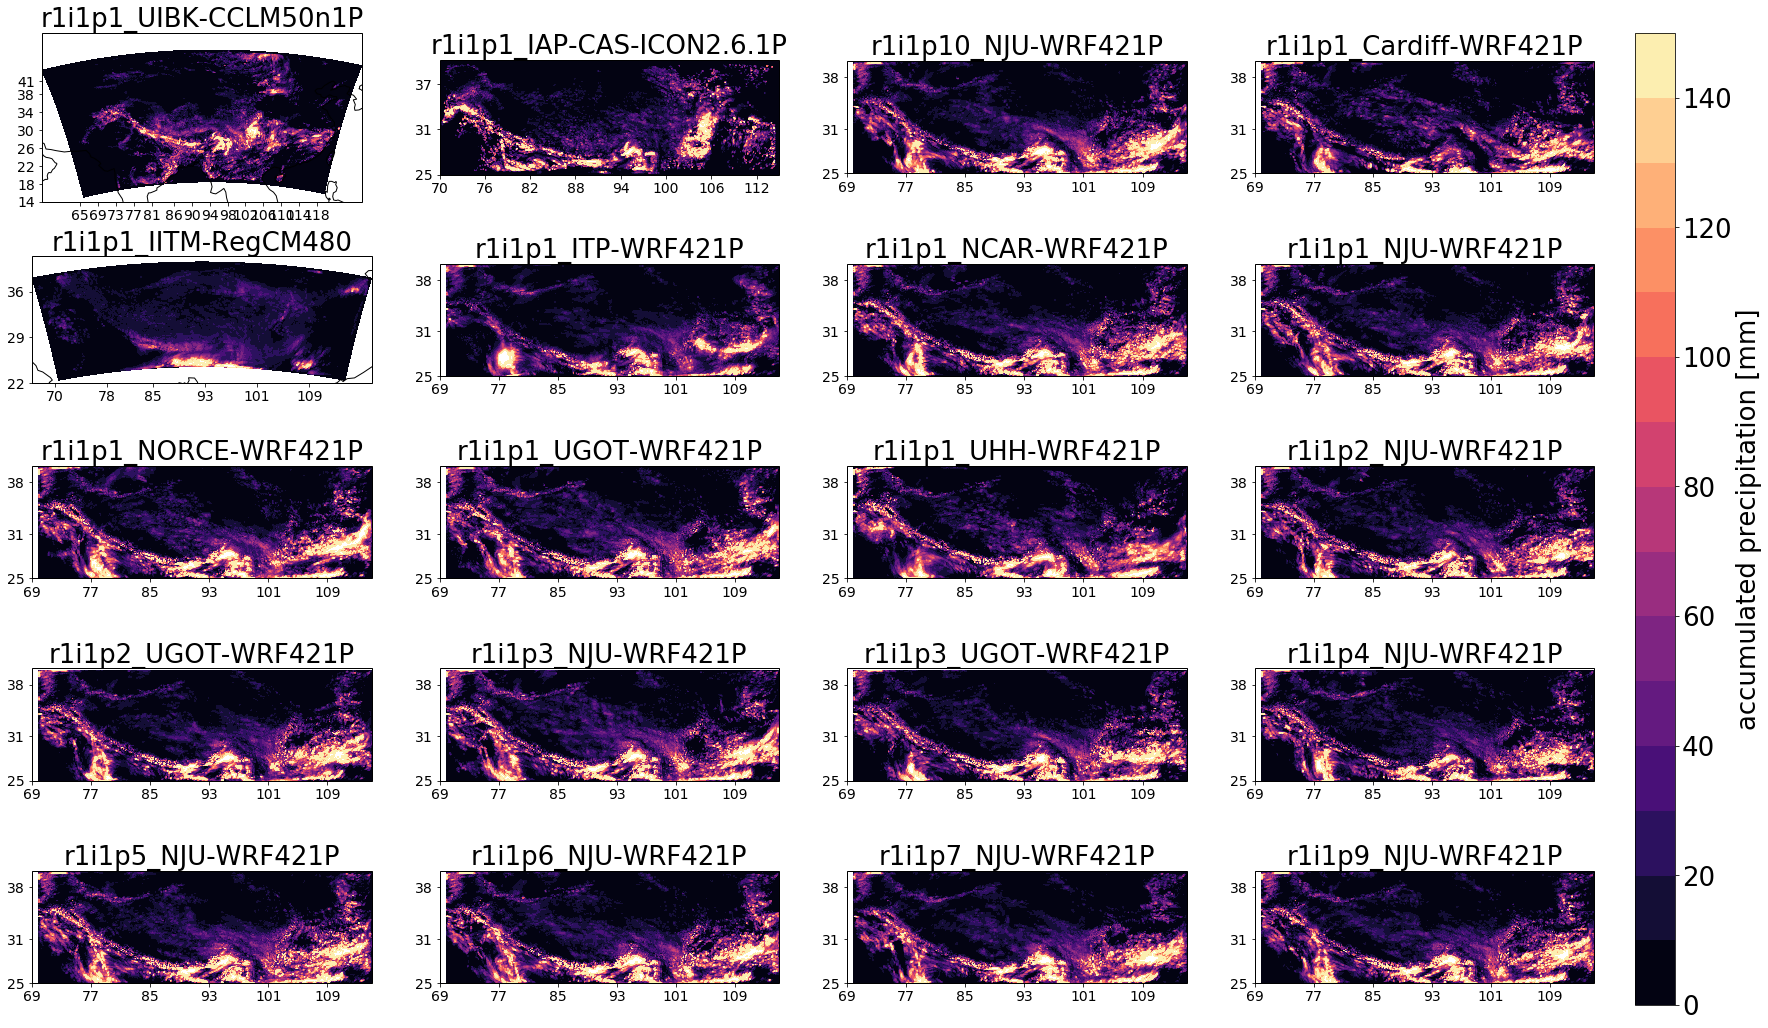

In [102]:
fig =plt.figure(figsize=(28,18))

# customizing of colorbar 
cmap=plt.cm.magma
r = np.arange(0,160,10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
levels = [0,10,20,30,50,100,150,200,250,300,500] 
fs= 26
p = 1

for f in file_list:
    # read in data 
    data = xr.open_dataset(f).pr[0] * 3600
    lon = data.lon
    lat = data.lat
    if lon.ndim == 1:
        xlon= lon[::200].values.astype(int)
        ylat= lat[::200].values.astype(int)
    else:
        xlon= lon[0][::200].values.astype(int)
        ylat= lat[:,0][::200].values.astype(int)
    name= experiments[p-1] 
    
    # make subplot 
    ax = plt.subplot(5, 4, p, projection=ccrs.PlateCarree())
    ax.set_extent([np.nanmin(lon),np.nanmax(lon),np.nanmin(lat),np.nanmax(lat)-2])
    m=ax.contourf(lon, lat, data, levels = r, cmap = cmap, vmin = 0 , vmax = 150)
    ax.coastlines(color = 'black')
    ax.set_xticks(xlon)
    ax.set_xticklabels(xlon, fontsize= 14)
    ax.set_yticks(ylat)
    ax.set_yticklabels(ylat, fontsize= 14)
    ax.set_title(name, fontsize= fs)
    p += 1 
    data.close()

cb_ax2 = fig.add_axes([0.92, 0.13,0.02, 0.75])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', label = 'accumulated precipitation [mm]')
plt.rcParams.update({'font.size': 26})
    
plt.tight_layout()
plt.savefig('comparison_map_accumulated_precip.png')
plt.show()